# Week 7 Linear Regression
### Chris Richards
#### Regis University, Spring 2019, Data Collection and Preparation


### Introduction
For this assignment I chose a data set found on the UCI Repository of Machine Learning.  The data set is a collection of medical information collected from post-operative patients.  The original researchers collected this data for the purpose of creating a machine learning algorithim to predict the discharge status of patients after surgery.  
  
  My objective for the assignment is to clean the data, handle missing values, perform descriptive statistics and visualizations in order to explore the data.  Feature analysis will be conducted.  Once those steps are performed a suitable machine learning algorithim will be selected.  The model will be run, results analyzed and tuned for optimization.
  #### What analysis question are we trying to answer?
  Is it possible to predict the discharge status of a post-operative patient based on the following factors:
    1. L-CORE (patient's internal temperature in C):
              high (> 37), mid (>= 36 and <= 37), low (< 36)
     2. L-SURF (patient's surface temperature in C):
              high (> 36.5), mid (>= 36.5 and <= 35), low (< 35)
     3. L-O2 (oxygen saturation in %):
              excellent (>= 98), good (>= 90 and < 98),
              fair (>= 80 and < 90), poor (< 80)
     4. L-BP (last measurement of blood pressure):
              high (> 130/90), mid (<= 130/90 and >= 90/70), low (< 90/70)
     5. SURF-STBL (stability of patient's surface temperature):
              stable, mod-stable, unstable
     6. CORE-STBL (stability of patient's core temperature)
              stable, mod-stable, unstable
     7. BP-STBL (stability of patient's blood pressure)
              stable, mod-stable, unstable
     8. COMFORT (patient's perceived comfort at discharge, measured as
              an integer between 0 and 20)

In [1]:
# change working directory
%cd "C:\Users\cr117\Documents\Regis\Data_Collection\Week7\"

C:\Users\cr117\Documents\Regis\Data_Collection\Week7


In [2]:
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

sns.set() # sets seaborn defaults for plotting

In [3]:
# Suppress a deprecation warning...

import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('post-operative.data', header=None)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
0    90 non-null object
1    90 non-null object
2    90 non-null object
3    90 non-null object
4    90 non-null object
5    90 non-null object
6    90 non-null object
7    90 non-null object
8    90 non-null object
dtypes: object(9)
memory usage: 6.4+ KB


In [6]:
df.head()

,0,1,2,3,4,5,6,7,8
0,mid,low,excellent,mid,stable,stable,stable,15,A
1,mid,high,excellent,high,stable,stable,stable,10,S
2,high,low,excellent,high,stable,stable,mod-stable,10,A
3,mid,low,good,high,stable,unstable,mod-stable,15,A
4,mid,mid,excellent,high,stable,stable,stable,10,A


#### Missing Data 

The documentation accompanying the data set indicates question marks were used to indicare missing data.  I'll use apply to with a lambda function and simple regex pattern to find the question marks.

In [7]:
qmarks = df.apply(lambda x: x.str.contains('\?'))

I'll take the sum of all the found question marks by column.

In [8]:
(qmarks==1).sum()

# https://stackoverflow.com/questions/27140860/count-occurrences-of-number-by-column-in-pandas-data-frame

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    3
8    0
dtype: int64

According to that result there are 3 question marks in the data, all of them in the column 7 indicating patient comfort.  These need to be handled in some fashion.  I'll check the count of the values found in column 7.

In [9]:
df[7].value_counts()

10    65
15    19
?      3
05     2
07     1
Name: 7, dtype: int64

The majority of the values in that column are '10', however, I would rather not use that number but will instead find the mean and replace the missing values with that.  
  I'll create a new column, 'comfort_int', that is the integer cast from the original patient comfort column.  

In [10]:
df['comfort_int'] = pd.to_numeric(df[7], errors='coerce').fillna(0).astype(np.int64)

In [11]:
#df['15'].where(df['15'] == '?'#
df['comfort_int'].mean()

10.577777777777778

The mean was calculated at 10.57.  I'll use 11 to replace the missing values.

In [12]:
df.replace('?', '11', inplace=True)
print(df.describe())
print(df.head())

       comfort_int
count    90.000000
mean     10.577778
std       3.005530
min       0.000000
25%      10.000000
50%      10.000000
75%      10.000000
max      15.000000
      0     1          2     3       4         5           6   7   8  \
0   mid   low  excellent   mid  stable    stable      stable  15   A   
1   mid  high  excellent  high  stable    stable      stable  10   S   
2  high   low  excellent  high  stable    stable  mod-stable  10   A   
3   mid   low       good  high  stable  unstable  mod-stable  15  A    
4   mid   mid  excellent  high  stable    stable      stable  10   A   

   comfort_int  
0           15  
1           10  
2           10  
3           15  
4           10  


The comfort_int column is no longer needed and will be dropped from the dataframe.

In [13]:
df.drop('comfort_int', axis=1, inplace=True)

I'll rerun the function to find question marks to check my work.

In [14]:
qmarks = df.apply(lambda x: x.str.contains('\?'))

In [15]:
(qmarks==1).sum()

# https://stackoverflow.com/questions/27140860/count-occurrences-of-number-by-column-in-pandas-data-frame

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
dtype: int64

No question marks were found indicating a succesful replacement.  
  
  Next, I'm going to make a copy of the dataframe and encode the categorical variables.

In [16]:
# encode levels:
# low=1
# mid=2
# high=3
# stable=1
# mod-stable=2
# unstable=3
# good=1
# excellent=2
dfc = df.copy()
dfc.replace(['low', 'mid', 'high', 'stable', 'mod-stable', 'unstable', 'good', 'excellent', 'A', 'I', 'S' ], [1,2,3,1,2,3,1,2,2,1,3], inplace=True)

Looking back on a previous describe function run on the dataframe something is off with the 8th column, 'decision'.  There is an "A" value that is aligned differently then the other values.  I suspect there may be a space added to the entry.  I'll check.

In [17]:
df[df[8]=='A ']

,0,1,2,3,4,5,6,7,8
3,mid,low,good,high,stable,unstable,mod-stable,15,A


My guess was correct and there is an extra space added to row 3 for that entry.  I'll correct it, and any others, with a replacement to "A".

In [18]:
df.replace('A ', 'A', inplace=True)

In [19]:
print(df.info())
print(df.head(1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 9 columns):
0    90 non-null object
1    90 non-null object
2    90 non-null object
3    90 non-null object
4    90 non-null object
5    90 non-null object
6    90 non-null object
7    90 non-null object
8    90 non-null object
dtypes: object(9)
memory usage: 6.4+ KB
None
     0    1          2    3       4       5       6   7  8
0  mid  low  excellent  mid  stable  stable  stable  15  A


At this point, I'm going to rename the columns to something more descriptive.

In [20]:
# rename columns
df.rename(columns={0 :'core_temp', 1:'surf_temp', 2:'o2sat', 3:'bp', 
                   4:'stbl_surf_temp', 5:'stbl_core_temp', 6:'stbl_bp', 
                   7:'comfort', 8:'decision'}, inplace=True)
dfc.rename(columns={0 :'core_temp', 1:'surf_temp', 2:'o2sat', 3:'bp', 
                   4:'stbl_surf_temp', 5:'stbl_core_temp', 6:'stbl_bp', 
                   7:'comfort', 8:'decision'}, inplace=True)

dfc.head(1)

,core_temp,surf_temp,o2sat,bp,stbl_surf_temp,stbl_core_temp,stbl_bp,comfort,decision
0,2,1,2,2,1,1,1,15,2


In [21]:
df.describe()

,core_temp,surf_temp,o2sat,bp,stbl_surf_temp,stbl_core_temp,stbl_bp,comfort,decision
count,90,90,90,90,90,90,90,90,90
unique,3,3,2,3,2,3,3,5,3
top,mid,mid,good,mid,stable,stable,stable,10,A
freq,58,48,47,57,45,83,46,65,64


I'd like to get an idea of the values in each column and their frequencies.  I'll use a for loop with value_counts to find them.

In [22]:
for c in df.columns:
    print ("---- %s ---" % c)
    print (df[c].value_counts())

---- core_temp ---
mid     58
low     19
high    13
Name: core_temp, dtype: int64
---- surf_temp ---
mid     48
low     25
high    17
Name: surf_temp, dtype: int64
---- o2sat ---
good         47
excellent    43
Name: o2sat, dtype: int64
---- bp ---
mid     57
high    30
low      3
Name: bp, dtype: int64
---- stbl_surf_temp ---
stable      45
unstable    45
Name: stbl_surf_temp, dtype: int64
---- stbl_core_temp ---
stable        83
unstable       6
mod-stable     1
Name: stbl_core_temp, dtype: int64
---- stbl_bp ---
stable        46
unstable      23
mod-stable    21
Name: stbl_bp, dtype: int64
---- comfort ---
10    65
15    19
11     3
05     2
07     1
Name: comfort, dtype: int64
---- decision ---
A    64
S    24
I     2
Name: decision, dtype: int64


## Feature Analysis
I'm now ready to explore the data in greater depth by plotting various features.  
I'll begin with a boxplot of all the features.

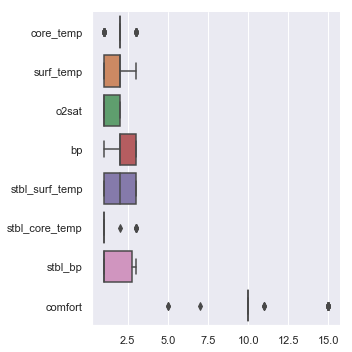

In [23]:
d = dfc.loc[:, dfc.columns]
sns.catplot(data=d, orient = 'h', kind="box");

It's obvious that this plot is being affected by the comfort series.  I'll remove it and replot to get a better view of the remaining series.

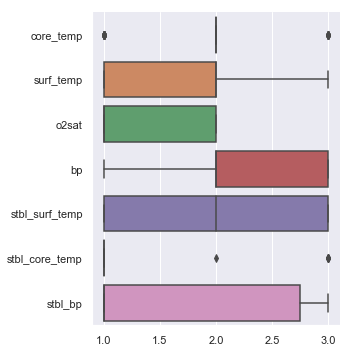

In [24]:
d = dfc.loc[:, dfc.columns != 'comfort']
sns.catplot(data=d, orient = 'h', kind="box");

After some thought, it appears that there are several patterns found in the distribution of the data.  For instance, core temperature and stability of core temperature have the majority of their points found at the mean with several outliers.  O2 saturation has no values at the high end with the remainder spread across the low and mid points.  
Blood pressure and surface temp are similar with the exception of outliers at the low and high ends, respectively.  
Stability of surface temperature and stability of blood pressure seem to be the most uniformly distributed features.

To further exam the distribution I'll use Seaborn to plot counts of various series.

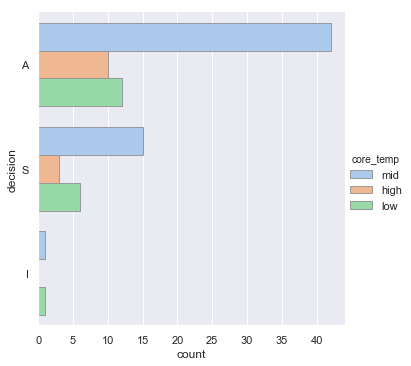

In [25]:
sns.catplot(y="decision", hue="core_temp", kind="count",
            palette="pastel", edgecolor=".6",
            data=df);

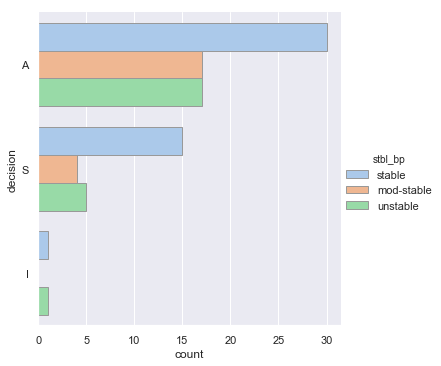

In [26]:
sns.catplot(y="decision", hue="stbl_bp", kind="count",
            palette="pastel", edgecolor=".6",
            data=df);

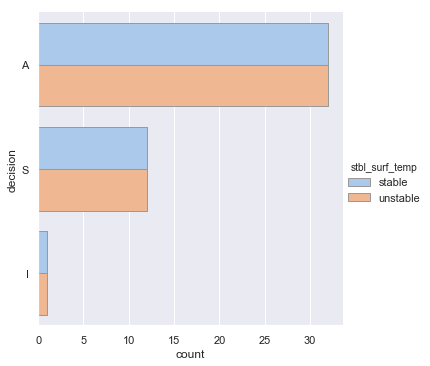

In [27]:
sns.catplot(y="decision", hue="stbl_surf_temp", kind="count",
            palette="pastel", edgecolor=".6",
            data=df);

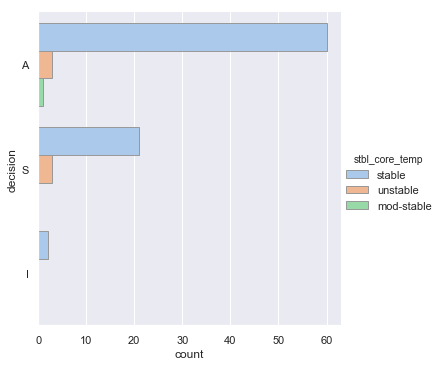

In [28]:
sns.catplot(y="decision", hue="stbl_core_temp", kind="count",
            palette="pastel", edgecolor=".6",
            data=df);

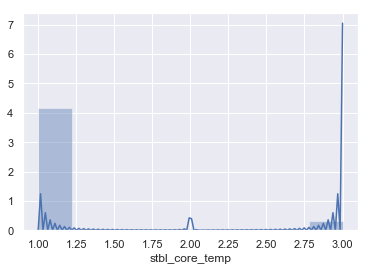

In [29]:
def hist_viz(df,feature):
    ax = sns.distplot(dfc[feature])
    plt.xlabel(feature)
    plt.show()
hist_viz(df,'stbl_core_temp')

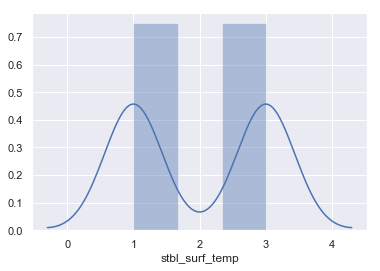

In [30]:
def hist_viz(df,feature):
    ax = sns.distplot(dfc[feature])
    plt.xlabel(feature)
    plt.show()
hist_viz(df,'stbl_surf_temp')

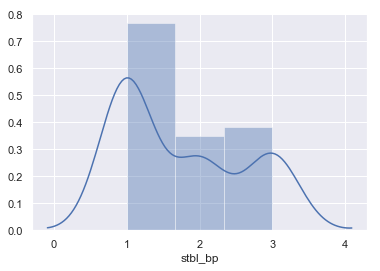

In [31]:
def hist_viz(df,feature):
    ax = sns.distplot(dfc[feature])
    plt.xlabel(feature)
    plt.show()
hist_viz(df,'stbl_bp')

These counts and histograms help to further visualize the results of the boxplot.  In particular, they help to confirm the impresion that stability of blood pressure and surface temperature are the most uniformly distributed.  
My understanding of machine learning, feature analysis and model tuning is limited at this point in my academic career.  I can only guess at the significance to a machine learning algorithim of uniformly distributed data.  I would tend to believe that a highly skewed data set would result in a poorly performing model.  

## Random Forest Model
Considering my data is largely categorical (the exception being patient comfort) and that I am attempting to classify a patient's post-operative discharge status which is chosen from a multifactor category, I decided to use a Random Forest model.  Researching algorithims it seems Random Forests are a good choice for classifying categorical data with a multifactorial response variable.

To begin, I will use the get_dummies method to create dummy variables from the categorical data.  To avoid covariance issues I will drop the reference variable from each series.

In [32]:
df_dummy = pd.get_dummies(df[['core_temp', 'surf_temp', 'o2sat', 'bp', 'stbl_surf_temp', 'stbl_core_temp', 'stbl_bp', 'decision']], drop_first=True)
df_dummy.columns

Index(['core_temp_low', 'core_temp_mid', 'surf_temp_low', 'surf_temp_mid',
       'o2sat_good', 'bp_low', 'bp_mid', 'stbl_surf_temp_unstable',
       'stbl_core_temp_stable', 'stbl_core_temp_unstable', 'stbl_bp_stable',
       'stbl_bp_unstable', 'decision_I', 'decision_S'],
      dtype='object')

Now that dummy variables are created I can split the data into source and target data.  
In this case, the target data are the dummy variabes created from the 'decision' series with source data consisting of the remaining series.

In [33]:
# split data into source (X) and target (y)
data_cols = ['core_temp_low', 'core_temp_mid', 'surf_temp_low', 'surf_temp_mid', 'bp_low', 'bp_mid', 'stbl_surf_temp_unstable',
       'o2sat_good','stbl_core_temp_stable', 'stbl_core_temp_unstable', 'stbl_bp_stable', 'stbl_bp_unstable']
target_cols = ['decision_I', 'decision_S']

X = df_dummy[data_cols]
y = df_dummy[target_cols]

I'm now ready to split the data into train and test sets.  I'll use train_test_split to do this.  The test size will be set at 30% of the data and a random seed established for reproducibility.

In [34]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

RandomForestClassifier will be imported along with accuracy_score from the sci kit learn library.  
An instance of the classifier will be created, the model will be fit using the training data and then used to make a prediction on the test data set.  
Finally, the accuracy of the model will be calculated using accuracy_score.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.feature_extraction.text import CountVectorizer

model = RandomForestClassifier()
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

accuracy_score(y_test.values, y_predict)

0.7777777777777778

The first pass of this model has yielded an accuracy score of 74%.  This is a respectable level of accuracy, however, I believe that using all of the independent variables in the data set has contributed significant noise to the model.  Further tuning of the model will likely yield a better score.  
### Tune model
Based on the earlier feature analysis I suspect removing some features, specifically bp, surf_temp, and o2sat will decrease the noise and yield a better result.  
I will rebuild the test and train data sets without those features and rerun the model.

In [36]:
# split data into source (X) and target (y)
data_cols = ['core_temp_low', 'core_temp_mid', 'stbl_surf_temp_unstable',
       'stbl_core_temp_stable', 'stbl_core_temp_unstable', 'stbl_bp_stable', 
        'stbl_bp_unstable']
target_cols = ['decision_I', 'decision_S']

X = df_dummy[data_cols]
y = df_dummy[target_cols]

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
# from sklearn.feature_extraction.text import CountVectorizer

model = RandomForestClassifier()
# vec = CountVectorizer()
# X = vec.fit_transform(df)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

accuracy_score(y_test.values, y_predict)

0.8888888888888888

As suspected, removing those oddly distributed features has increased the accuracy of the model to 81.5%  
Going back to the earlier plots I'm curious to see how the model will perform with only the uniformly distributed features provided as input variable.  
I'll remove the rest of the features and leave only the stability of blood pressure and surface temperature features.


In [39]:
# split data into source (X) and target (y)
data_cols = [ 'stbl_surf_temp_unstable', 'stbl_bp_stable', 'stbl_bp_unstable']
target_cols = ['decision_I', 'decision_S']

X = df_dummy[data_cols]
y = df_dummy[target_cols]

In [42]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [192]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

model = RandomForestClassifier()
# vec = CountVectorizer()
# X = vec.fit_transform(df)
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

accuracy_score(y_test.values, y_predict)

0.8888888888888888

### GridSearchCV

In [44]:
param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model, cv = 10,
                     param_grid=param_dist,
                     n_jobs = 3)

cv_rf.fit(X_train, y_train)
print('Best Parameters using grid search: \n',
      cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 2, 'max_features': 'auto'}


In [50]:
model = RandomForestClassifier(bootstrap= True, criterion= 'entropy', max_depth= 2, max_features= 'auto')
model.fit(X_train, y_train)
y_predict = model.predict(X_test)

accuracy_score(y_test.values, y_predict)

0.8888888888888888

RERUN THE RF MODEL WITH THE NEW PARAMETERS ON THE ENTIRE DF (BEFORE REMOVING FEATURES)  

  Accuracy of the model has jumped to 89%.  At this point with my limited knowledge of algorithim tuning I'm considering this model fully optimized.  


## Final Analysis
In conclusion, it appears that the answer to the analysis question posed at the beginning of the project is that it is possible to predict the discharge status with a high level of accuracy.  The analysis was useful in that it refined the model by reducing the number of input features.  The two remaining features, stability of surface body temperature and stability of blood pressure were sufficient to obtain 89% accuracy.  
  
  This analysis would benefit from a larger data set in the future.  The total population of observations was 90 patients.  
    
I learned quite a bit about machine learning during this assignement.  My early attempts at selecting a model were based on little experience with machine learning.  This led to selecting inappropriate models - linear regression, for instance - for this data set.  In addition, the categorical nature of the data reduced the number of models significantly, which I only discovered after much research.  
  
  Future work on this analysis could involve the use of other models, other techniques for feature engineering and model tuning.  